<a href="https://colab.research.google.com/github/fjadidi2001/fake_news_detection/blob/main/fake_news4thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ==========================================
# STEP 1: SETUP AND IMPORTS & DETERMINISTIC SETUP
# ==========================================
import os
import shutil # Needed to remove cache files
# Install dependencies
!pip install torch-geometric imbalanced-learn -q
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from scipy import io as sio
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from torch.utils.data import TensorDataset, DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
# Set style for better plots
sns.set_palette("dark")

# ==========================================
# COMPREHENSIVE REPRODUCIBILITY SETUP
# ==========================================
def set_all_seeds(seed=42):
    """Set all possible seeds for reproducibility"""
    # Python random
    import random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Only set these if CUDA is available and working
        try:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
            # CRITICAL FIX: Set additional CUDA flags for full determinism
            torch.use_deterministic_algorithms(True, warn_only=True)
        except Exception as e:
            print(f"Warning: Could not set CUDNN settings: {e}")
    # Environment variables for additional determinism
    os.environ['PYTHONHASHSEED'] = str(seed)
    # CRITICAL FIX: Additional environment variables
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

# Apply comprehensive seed setting
set_all_seeds(42)
print("✅ All libraries imported and seeds set for reproducibility!")

# ==========================================
# DEBUG HELPER FUNCTIONS
# ==========================================
def debug_tensor(tensor, name):
    """Debug tensor properties"""
    print(f"Debug {name}:")
    print(f"  Shape: {tensor.shape}")
    print(f"  Dtype: {tensor.dtype}")
    print(f"  Device: {tensor.device}")
    print(f"  Min: {tensor.min().item()}")
    print(f"  Max: {tensor.max().item()}")
    print(f"  Has NaN: {torch.isnan(tensor).any().item()}")
    print(f"  Has Inf: {torch.isinf(tensor).any().item()}")
    if len(tensor.shape) == 1:
        print(f"  Unique values: {torch.unique(tensor).cpu().numpy()}")

def validate_labels(labels, num_classes=2):
    """Validate labels for classification"""
    unique_labels = np.unique(labels)
    print(f"Label validation:")
    print(f"  Unique labels: {unique_labels}")
    print(f"  Expected range: [0, {num_classes-1}]")
    print(f"  All labels valid: {all(0 <= label < num_classes for label in unique_labels)}")
    return all(0 <= label < num_classes for label in unique_labels)

# ==========================================
# STEP 2: DATA LOADING AND INITIAL EXPLORATION
# ==========================================
# Mount Google Drive
drive.mount('/content/drive')

# CRITICAL FIX: Force reprocessing by clearing/disabling cache
USE_CACHE = False # <--- SET THIS TO False TO FORCE REPROCESSING

dataset_cache_path = '/content/drive/MyDrive/Projects/Hayat/dataset_cache.pkl'
# Clear cache file if it exists and we want to force reprocessing
if not USE_CACHE and os.path.exists(dataset_cache_path):
    try:
        os.remove(dataset_cache_path)
        print("🗑️ Cleared dataset cache file.")
    except Exception as e:
        print(f"⚠️ Could not remove dataset cache: {e}")

if USE_CACHE:
    try:
        # Try to load cached dataset
        import pickle
        with open(dataset_cache_path, 'rb') as f:
            df = pickle.load(f)
        print("✅ Loaded cached dataset")
    except Exception as e:
        print(f"⚠️ Cache load failed ({e}), loading from CSV...")
        df = pd.read_csv('/content/drive/MyDrive/Projects/Hayat/facebook-fact-check.csv', encoding='latin-1')
        # IMPORTANT: Sort dataframe to ensure consistent ordering
        df = df.sort_values(['account_id', 'post_id']).reset_index(drop=True)
        # Cache the processed dataset
        try:
            with open(dataset_cache_path, 'wb') as f:
                pickle.dump(df, f)
            print("✅ Dataset cached for future runs")
        except Exception as e2:
            print(f"⚠️ Could not cache dataset: {e2}")
else:
    print("🔄 Loading dataset from CSV (cache disabled)...")
    df = pd.read_csv('/content/drive/MyDrive/Projects/Hayat/facebook-fact-check.csv', encoding='latin-1')
    # IMPORTANT: Sort dataframe to ensure consistent ordering
    df = df.sort_values(['account_id', 'post_id']).reset_index(drop=True)
    print("✅ Dataset loaded from CSV")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
# Basic statistics
print(f"\nDataset Info:")
print(f"Number of samples: {len(df)}")
print(f"Number of features: {df.shape[1]}")
print(f"Missing values per column:")
print(df.isnull().sum())

# ==========================================
# STEP 3: NETWORK FEATURES PREPROCESSING
# ==========================================
def preprocess_network_features(df, random_state=42):
    """Enhanced preprocessing with DETERMINISTIC outlier handling"""
    # CRITICAL FIX: Set random state for pandas operations
    np.random.seed(random_state)
    # Extract network features in consistent order
    network_cols = ['share_count', 'reaction_count', 'comment_count']
    features = df[network_cols].copy()
    # CRITICAL FIX: Handle missing values with DETERMINISTIC median
    # Calculate medians once and reuse
    medians = {}
    for col in network_cols:
        medians[col] = features[col].median()
        features[col] = features[col].fillna(medians[col])
    # Log transform to handle skewness (add 1 to avoid log(0))
    features_log = np.log1p(features)
    # CRITICAL FIX: Deterministic outlier capping with consistent percentiles
    for col in features_log.columns:
        # Use exactly the same quantile calculation method
        q99 = np.percentile(features_log[col].values, 99)
        features_log[col] = features_log[col].clip(upper=q99)
    return features_log.values, features.values

# Preprocess network features deterministically
network_features_processed, network_features_raw = preprocess_network_features(df, random_state=42)
print("✅ Network features preprocessed")
print(f"Raw features shape: {network_features_raw.shape}")
print(f"Processed features shape: {network_features_processed.shape}")
# CRITICAL FIX: Use deterministic StandardScaler
scaler = StandardScaler()
# Set random state internally for sklearn operations
set_all_seeds(42)
X_net_std = scaler.fit_transform(network_features_processed)
print(f"Standardized features shape: {X_net_std.shape}")
print(f"NaN check: {np.isnan(X_net_std).any()}")
# Save for later use (can keep saving, but loading is controlled by USE_CACHE)
try:
    sio.savemat('/content/drive/MyDrive/Projects/Hayat/network_processed.mat', {
        'X_net_std': X_net_std,
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_
    })
except Exception as e:
    print(f"⚠️ Could not save network features: {e}")

# ==========================================
# STEP 4: LABEL PREPARATION AND ANALYSIS
# ==========================================
print("\n🔍 Analyzing labels...")
print(f"Unique ratings: {df['Rating'].value_counts().sort_index()}")  # FIXED: sort for consistency
# Create binary labels - CRITICAL FIX: More explicit mapping
def create_binary_labels(rating_series):
    """Create binary labels deterministically"""
    labels = []
    for rating in rating_series:
        if rating == 'mostly true':
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels)
y = create_binary_labels(df['Rating'])
# VALIDATE LABELS
print(f"Label distribution: {np.bincount(y)}")
print(f"Class 0 (mostly true): {np.bincount(y)[0]} ({np.bincount(y)[0]/len(y)*100:.1f}%)")
print(f"Class 1 (others): {np.bincount(y)[1]} ({np.bincount(y)[1]/len(y)*100:.1f}%)")
# CRITICAL: Validate labels are in correct range
if not validate_labels(y, num_classes=2):
    raise ValueError("Labels contain invalid values! Must be in range [0, 1]")
print("✅ Labels validated successfully")

# ==========================================
# STEP 5: IMPROVED GRAPH CONSTRUCTION
# ==========================================
def construct_meaningful_graph(df, X_net_std, method='hybrid', similarity_threshold=0.7, max_connections=5, random_state=42):
    """
    FIXED: Construct graph with FULLY deterministic connections
    """
    # CRITICAL FIX: Set seeds at the beginning
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    G = nx.Graph()
    # Add nodes with features in deterministic order
    for idx in range(len(df)):
        G.add_node(idx, features=X_net_std[idx])
    if method == 'similarity':
        # Similarity-based edges
        similarity_matrix = cosine_similarity(X_net_std)
        for i in range(len(df)):
            # CRITICAL FIX: Use argsort for deterministic ordering
            similarities = similarity_matrix[i]
            # Get indices sorted by similarity (excluding self)
            similar_indices = np.argsort(similarities)[::-1]
            similar_indices = similar_indices[similar_indices != i]  # Remove self
            similar_indices = similar_indices[:max_connections]  # Limit connections
            for j in similar_indices:
                if similarities[j] > similarity_threshold:
                    G.add_edge(i, j, weight=float(similarities[j]))
    elif method == 'account':
        # Account-based edges (limited and deterministic)
        account_groups = df.groupby('account_id').indices
        for account_id in sorted(account_groups.keys()):  # CRITICAL FIX: Sort account IDs
            indices = sorted(list(account_groups[account_id]))  # Sort indices
            if len(indices) > 1:
                # Connect only recent posts (limit connections)
                for i in range(min(len(indices), max_connections)):
                    for j in range(i + 1, min(len(indices), max_connections)):
                        G.add_edge(indices[i], indices[j], weight=1.0)
    elif method == 'hybrid':
        # CRITICAL FIX: Combination of both methods with deterministic order
        # First add account-based edges
        account_groups = df.groupby('account_id').indices
        for account_id in sorted(account_groups.keys()):  # Sort account IDs
            indices = sorted(list(account_groups[account_id]))  # Sort indices
            if len(indices) > 1:
                for i in range(min(len(indices), 3)):  # Limit account connections
                    for j in range(i + 1, min(len(indices), 3)):
                        G.add_edge(indices[i], indices[j], weight=1.0)
        # Then add similarity-based edges deterministically
        similarity_matrix = cosine_similarity(X_net_std)
        for i in range(len(df)):
            similarities = similarity_matrix[i]
            # CRITICAL FIX: Use argsort for deterministic similar node selection
            similar_indices = np.argsort(similarities)[::-1]
            similar_indices = similar_indices[similar_indices != i]  # Remove self
            similar_indices = similar_indices[:3]  # Top 3 similar
            for j in similar_indices:
                if similarities[j] > similarity_threshold and not G.has_edge(i, j):
                    G.add_edge(i, j, weight=float(similarities[j]))
    return G

# Construct graph deterministically
print(f"\n🔄 Constructing graph with hybrid method...")
set_all_seeds(42)  # Reset seeds before graph construction
final_graph = construct_meaningful_graph(df, X_net_std, method='hybrid', random_state=42)
print(f"✅ Final graph selected: {final_graph.number_of_nodes()} nodes, {final_graph.number_of_edges()} edges")

# ==========================================
# STEP 6: CONVERT GRAPH FOR PYG & DEFINE IMPROVED GCN MODEL
# ==========================================
# Convert NetworkX graph to PyTorch Geometric format with consistent ordering
edges = sorted(list(final_graph.edges))  # Sort edges for consistency
if len(edges) == 0:
    # Create self-loops for all nodes if graph is empty
    edge_index = torch.arange(len(df), dtype=torch.long).repeat(2, 1)
else:
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    # Ensure edge_index is of shape [2, num_edges]
    assert edge_index.shape[0] == 2, f"Edge index must have shape [2, num_edges], got {edge_index.shape}"

# CRITICAL: Validate edge indices
max_node_idx = len(df) - 1
if edge_index.numel() > 0:  # Check if edge_index is not empty
    if edge_index.max().item() > max_node_idx or edge_index.min().item() < 0:
        raise ValueError(f"Invalid edge indices! Max: {edge_index.max().item()}, Min: {edge_index.min().item()}, Expected range: [0, {max_node_idx}]")

x = torch.tensor(X_net_std, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
# Add self-loops deterministically
edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)
data.edge_index = edge_index
print(f"PyTorch Geometric Data: {data}")

# CRITICAL FIX: Define improved GCN model with DETERMINISTIC initialization
class ImprovedGCN(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=128, dropout=0.3, seed=42):
        super(ImprovedGCN, self).__init__()
        self.seed = seed
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.init_weights()  # Deterministic init

    def init_weights(self):
        """Initialize weights DETERMINISTICALLY with fixed seed"""
        torch.manual_seed(self.seed)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                torch.nn.init.ones_(m.weight)
                torch.nn.init.zeros_(m.bias)

    def forward(self, x, edge_index):
        # x shape: [num_nodes, in_channels]
        # edge_index shape: [2, num_edges]
        # Debug inputs
        if torch.isnan(x).any() or torch.isinf(x).any():
            raise ValueError("Input features contain NaN or Inf values!")
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        # x shape: [num_nodes, out_channels]
        return x

# Initialize and get GCN embeddings (Pre-compute GCN embeddings)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move to CPU first for debugging
print("🔍 Running GCN on CPU first for debugging...")
set_all_seeds(42)  # CRITICAL: Reset seeds before model creation
gcn_model = ImprovedGCN(seed=42)
data_cpu = data.to('cpu')

# Get GCN embeddings (from untrained model - used as pre-computed features)
gcn_model.eval()
with torch.no_grad():
    try:
        gcn_embeddings = gcn_model(data_cpu.x, data_cpu.edge_index)
        print("✅ GCN forward pass successful on CPU")
    except Exception as e:
        print(f"❌ GCN forward pass failed on CPU: {e}")
        raise

# Now move to GPU if available
if device.type == 'cuda':
    print("🔄 Moving to GPU...")
    try:
        gcn_model = gcn_model.to(device)
        data = data.to(device)
        gcn_model.eval()
        with torch.no_grad():
            gcn_embeddings = gcn_model(data.x, data.edge_index)
            print("✅ GCN forward pass successful on GPU")
    except Exception as e:
        print(f"❌ GCN forward pass failed on GPU, using CPU results: {e}")
        gcn_model = gcn_model.to('cpu')
        data = data.to('cpu')
        device = torch.device('cpu')

print(f"GCN embeddings shape: {gcn_embeddings.shape}")
print(f"NaN check: {torch.isnan(gcn_embeddings).any().item()}")

# Save GCN model and embeddings (can keep saving)
try:
    torch.save(gcn_model.state_dict(), '/content/drive/MyDrive/Projects/Hayat/improved_gcn_model.pth')
    torch.save(gcn_embeddings.cpu(), '/content/drive/MyDrive/Projects/Hayat/gcn_embeddings.pt')
    print("✅ GCN model and embeddings saved")
except Exception as e:
    print(f"⚠️ Could not save GCN results: {e}")

# ==========================================
# STEP 7: BERT MODEL AND TEXT BRANCH
# ==========================================
# CRITICAL FIX: Define improved attention mechanism with DETERMINISTIC initialization
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=8, seed=42):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_heads
        self.seed = seed
        assert self.head_dim * num_heads == hidden_dim, "hidden_dim must be divisible by num_heads"

        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, hidden_dim)

        self.init_weights()  # Deterministic init

    def init_weights(self):
        """Initialize weights DETERMINISTICALLY"""
        torch.manual_seed(self.seed)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

    def forward(self, embeddings):
        batch_size, seq_len, hidden_dim = embeddings.shape
        # Generate Q, K, V
        Q = self.query(embeddings).view(batch_size, seq_len, self.num_heads, self.head_dim)
        K = self.key(embeddings).view(batch_size, seq_len, self.num_heads, self.head_dim)
        V = self.value(embeddings).view(batch_size, seq_len, self.num_heads, self.head_dim)

        # Transpose for attention computation
        Q = Q.transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.head_dim)
        attention_weights = torch.softmax(scores, dim=-1)

        # Apply attention
        context = torch.matmul(attention_weights, V)

        # Reshape and output
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, hidden_dim)
        output = self.output(context)

        # Global average pooling
        output = output.mean(dim=1)  # (batch_size, hidden_dim)
        return output, attention_weights

# CRITICAL FIX: Force BERT reprocessing by clearing/disabling cache
bert_cache_path = '/content/drive/MyDrive/Projects/Hayat/bert_embeddings_cache.pt'
# Clear cache file if it exists and we want to force reprocessing
if not USE_CACHE and os.path.exists(bert_cache_path):
     try:
         os.remove(bert_cache_path)
         print("🗑️ Cleared BERT cache file.")
     except Exception as e:
         print(f"⚠️ Could not remove BERT cache: {e}")

if USE_CACHE:
    try:
        # Try to load cached BERT embeddings
        bert_embeddings = torch.load(bert_cache_path)
        print("✅ Loaded cached BERT embeddings")
    except Exception as e:
        print(f"⚠️ BERT cache load failed ({e}), running BERT...")
        # ... (rest of BERT processing code if cache fails) ...
        # Initialize BERT and attention with deterministic settings
        set_all_seeds(42)
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
        bert_model.eval()
        # Freeze BERT weights (common practice for feature extraction)
        for param in bert_model.parameters():
            param.requires_grad = False
        attention_layer = MultiHeadAttention(hidden_dim=768, num_heads=8, seed=42).to(device)

        # Process texts with BERT deterministically
        batch_size = 16 # Keep batch size small to manage memory
        bert_embeddings = []
        texts = df['Context Post'].fillna("").tolist()
        print(f"Processing {len(texts)} texts for BERT embeddings...")
        # CRITICAL FIX: Calculate optimal max_length DETERMINISTICALLY
        set_all_seeds(42)
        sample_texts = texts[:100] if len(texts) > 100 else texts  # Consistent sample
        text_lengths = [len(tokenizer.tokenize(text)) for text in sample_texts]
        optimal_max_length = int(np.percentile(text_lengths, 95))
        optimal_max_length = min(optimal_max_length, 512)  # Cap at BERT max
        print(f"Optimal max_length: {optimal_max_length}")

        # Pre-compute BERT embeddings deterministically
        try:
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i + batch_size]
                # CRITICAL FIX: Deterministic tokenization
                inputs = tokenizer(
                    batch_texts,
                    return_tensors='pt',
                    padding='max_length',  # FIXED: Use max_length padding
                    truncation=True,
                    max_length=optimal_max_length
                )
                inputs = {k: v.to(device) for k, v in inputs.items()}
                with torch.no_grad():
                    outputs = bert_model(**inputs)
                    token_embeddings = outputs.last_hidden_state
                    context_vector, _ = attention_layer(token_embeddings)
                    bert_embeddings.append(context_vector.cpu())
            bert_embeddings = torch.cat(bert_embeddings, dim=0)
            # Cache the BERT embeddings
            try:
                torch.save(bert_embeddings, bert_cache_path)
                print("✅ BERT embeddings cached for future runs")
            except Exception as e2:
                print(f"⚠️ Could not cache BERT embeddings: {e2}")
        except Exception as e:
            print(f"❌ BERT processing failed: {e}")
            print("Using CPU for BERT processing...")
            # Fallback to CPU with same deterministic approach
            bert_model = bert_model.to('cpu')
            attention_layer = attention_layer.to('cpu')
            device_bert = torch.device('cpu')
            bert_embeddings = []
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i + batch_size]
                inputs = tokenizer(
                    batch_texts,
                    return_tensors='pt',
                    padding='max_length',
                    truncation=True,
                    max_length=optimal_max_length
                )
                inputs = {k: v.to(device_bert) for k, v in inputs.items()}
                with torch.no_grad():
                    outputs = bert_model(**inputs)
                    token_embeddings = outputs.last_hidden_state
                    context_vector, _ = attention_layer(token_embeddings)
                    bert_embeddings.append(context_vector.cpu())
            bert_embeddings = torch.cat(bert_embeddings, dim=0)
            # Cache the BERT embeddings
            try:
                torch.save(bert_embeddings, bert_cache_path)
                print("✅ BERT embeddings cached (CPU) for future runs")
            except Exception as e2:
                print(f"⚠️ Could not cache BERT embeddings (CPU): {e2}")
else:
    print("🔄 Running BERT embedding generation (cache disabled)...")
    # Initialize BERT and attention with deterministic settings
    set_all_seeds(42)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
    bert_model.eval()
    # Freeze BERT weights (common practice for feature extraction)
    for param in bert_model.parameters():
        param.requires_grad = False
    attention_layer = MultiHeadAttention(hidden_dim=768, num_heads=8, seed=42).to(device)

    # Process texts with BERT deterministically
    # Reduce batch size slightly to ensure longer runtime if needed
    batch_size = 8 # <--- Reduced batch size to increase processing time per step
    bert_embeddings = []
    texts = df['Context Post'].fillna("").tolist()
    print(f"Processing {len(texts)} texts for BERT embeddings (Batch Size: {batch_size})...")
    # CRITICAL FIX: Calculate optimal max_length DETERMINISTICALLY
    set_all_seeds(42)
    sample_texts = texts[:100] if len(texts) > 100 else texts  # Consistent sample
    text_lengths = [len(tokenizer.tokenize(text)) for text in sample_texts]
    optimal_max_length = int(np.percentile(text_lengths, 95))
    optimal_max_length = min(optimal_max_length, 512)  # Cap at BERT max
    print(f"Optimal max_length: {optimal_max_length}")

    # Pre-compute BERT embeddings deterministically
    # Add a loop counter to monitor progress
    total_batches = (len(texts) + batch_size - 1) // batch_size
    for i in range(0, len(texts), batch_size):
        batch_idx = i // batch_size + 1
        print(f"  Processing BERT batch {batch_idx}/{total_batches}...")
        batch_texts = texts[i:i + batch_size]
        # CRITICAL FIX: Deterministic tokenization
        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            padding='max_length',  # FIXED: Use max_length padding
            truncation=True,
            max_length=optimal_max_length
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
            token_embeddings = outputs.last_hidden_state
            context_vector, _ = attention_layer(token_embeddings)
            bert_embeddings.append(context_vector.cpu())
        # Optional: Add a tiny delay to ensure processing takes time (not usually necessary)
        # import time; time.sleep(0.01)
    bert_embeddings = torch.cat(bert_embeddings, dim=0)
    # Cache the BERT embeddings (can still save for next time)
    try:
        torch.save(bert_embeddings, bert_cache_path)
        print("✅ BERT embeddings cached for future runs")
    except Exception as e:
        print(f"⚠️ Could not cache BERT embeddings: {e}")

print(f"Pre-computed BERT embeddings shape: {bert_embeddings.shape}")
print(f"NaN check: {torch.isnan(bert_embeddings).any().item()}")

# Save BERT embeddings
try:
    torch.save(bert_embeddings, '/content/drive/MyDrive/Projects/Hayat/bert_embeddings_improved.pt')
    print("✅ BERT embeddings saved (backup)")
except Exception as e:
    print(f"⚠️ Could not save BERT embeddings (backup): {e}")

# ==========================================
# STEP 8: TWO-BRANCH ARCHITECTURE IMPLEMENTATION
# ==========================================
class TwoBranchClassifier(nn.Module):
    def __init__(self, gcn_dim=128, bert_dim=768, hidden_dim=256, num_classes=2, dropout=0.4, seed=42):
        super(TwoBranchClassifier, self).__init__()
        self.seed = seed
        # --- Social Branch (uses pre-computed GCN features) ---
        self.social_branch = nn.Sequential(
            nn.Linear(gcn_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        # --- Text Branch (uses pre-computed BERT features) ---
        self.text_branch = nn.Sequential(
            nn.Linear(bert_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        # --- Fusion layer with attention ---
        self.fusion_attention = nn.Sequential(
            nn.Linear(num_classes * 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 2),  # Attention weights for social and text
            nn.Softmax(dim=1)
        )
        # Optional final classifier layer
        self.final_classifier = nn.Linear(num_classes, num_classes)
        self.init_weights()  # Deterministic init

    def init_weights(self):
        """Initialize weights DETERMINISTICALLY"""
        torch.manual_seed(self.seed)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                torch.nn.init.ones_(m.weight)
                torch.nn.init.zeros_(m.bias)

    def forward(self, gcn_features, bert_features):
        # Debug inputs
        if torch.isnan(gcn_features).any() or torch.isinf(gcn_features).any():
            raise ValueError("GCN features contain NaN or Inf values!")
        if torch.isnan(bert_features).any() or torch.isinf(bert_features).any():
            raise ValueError("BERT features contain NaN or Inf values!")

        # Get predictions from both branches
        social_out = self.social_branch(gcn_features)  # [batch_size, num_classes]
        text_out = self.text_branch(bert_features)   # [batch_size, num_classes]

        # Concatenate for attention computation
        combined = torch.cat([social_out, text_out], dim=1)  # [batch_size, num_classes*2]
        attention_weights = self.fusion_attention(combined)  # [batch_size, 2]

        weighted_social = social_out * attention_weights[:, 0:1]
        weighted_text = text_out * attention_weights[:, 1:2]
        final_features = weighted_social + weighted_text

        final_out = self.final_classifier(final_features)  # [batch_size, num_classes]
        return final_out, social_out, text_out, attention_weights

# Initialize the model with deterministic weights
set_all_seeds(42)
two_branch_model = TwoBranchClassifier(seed=42).to(device)
print(f"Model parameters: {sum(p.numel() for p in two_branch_model.parameters()):,}")
print("✅ Two-Branch Classifier (using pre-computed embeddings) defined")

# ==========================================
# STEP 9: DATA PREPARATION AND SMOTE
# ==========================================
# CRITICAL FIX: Force SMOTE reprocessing by clearing/disabling cache
smote_cache_path = '/content/drive/MyDrive/Projects/Hayat/smote_cache.pkl'
# Clear cache file if it exists and we want to force reprocessing
if not USE_CACHE and os.path.exists(smote_cache_path):
     try:
         os.remove(smote_cache_path)
         print("🗑️ Cleared SMOTE cache file.")
     except Exception as e:
         print(f"⚠️ Could not remove SMOTE cache: {e}")

if USE_CACHE:
    try:
        # Try to load cached SMOTE results
        import pickle
        with open(smote_cache_path, 'rb') as f:
            cached_data = pickle.load(f)
        X_gcn_train, X_gcn_test, X_bert_train, X_bert_test, y_train, y_test = cached_data
        print("✅ Loaded cached SMOTE and train/test split results")
    except Exception as e:
        print(f"⚠️ SMOTE cache load failed ({e}), running SMOTE...")
        # Address class imbalance with SMOTE (deterministic)
        # Use pre-computed GCN and BERT embeddings for SMOTE
        print(f"\nOriginal class distribution: {np.bincount(y)}")
        # CRITICAL: Validate labels again before SMOTE
        if not validate_labels(y, num_classes=2):
            raise ValueError("Labels contain invalid values before SMOTE!")
        # Prepare data for SMOTE: Use pre-computed GCN and BERT embeddings
        X_for_smote = np.concatenate([gcn_embeddings.cpu().numpy(), bert_embeddings.numpy()], axis=1)
        print(f"Combined embeddings for SMOTE shape: {X_for_smote.shape}")
        # CRITICAL FIX: Use SMOTE with explicit random state
        set_all_seeds(42)
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_resampled, y_resampled = smote.fit_resample(X_for_smote, y)
        # CRITICAL: Validate resampled labels
        print(f"After SMOTE - class distribution: {np.bincount(y_resampled)}")
        if not validate_labels(y_resampled, num_classes=2):
            raise ValueError("Resampled labels contain invalid values!")
        # Split resampled data back into components
        X_gcn_resampled = X_resampled[:, :gcn_embeddings.shape[1]]  # First part: GCN embeddings
        X_bert_resampled = X_resampled[:, gcn_embeddings.shape[1]:]  # Second part: BERT embeddings
        print(f"Resampled GCN embeddings shape: {X_gcn_resampled.shape}")
        print(f"Resampled BERT embeddings shape: {X_bert_resampled.shape}")
        # CRITICAL FIX: Train-test split with explicit random state
        set_all_seeds(42)
        X_gcn_train, X_gcn_test, X_bert_train, X_bert_test, y_train, y_test = train_test_split(
            X_gcn_resampled, X_bert_resampled, y_resampled,
            test_size=0.2, random_state=42, stratify=y_resampled
        )
        # Cache the results
        cached_data = (X_gcn_train, X_gcn_test, X_bert_train, X_bert_test, y_train, y_test)
        try:
            with open(smote_cache_path, 'wb') as f:
                pickle.dump(cached_data, f)
            print("✅ SMOTE and train/test split results cached for future runs")
        except Exception as e2:
             print(f"⚠️ Could not cache SMOTE results: {e2}")
else:
    print("🔄 Running SMOTE and train/test split (cache disabled)...")
    # Address class imbalance with SMOTE (deterministic)
    # Use pre-computed GCN and BERT embeddings for SMOTE
    print(f"\nOriginal class distribution: {np.bincount(y)}")
    # CRITICAL: Validate labels again before SMOTE
    if not validate_labels(y, num_classes=2):
        raise ValueError("Labels contain invalid values before SMOTE!")
    # Prepare data for SMOTE: Use pre-computed GCN and BERT embeddings
    X_for_smote = np.concatenate([gcn_embeddings.cpu().numpy(), bert_embeddings.numpy()], axis=1)
    print(f"Combined embeddings for SMOTE shape: {X_for_smote.shape}")
    # CRITICAL FIX: Use SMOTE with explicit random state
    set_all_seeds(42)
    # Slightly increase SMOTE complexity by reducing k_neighbors (makes it work harder with less data)
    smote = SMOTE(random_state=42, k_neighbors=3) # <--- Reduced k_neighbors
    X_resampled, y_resampled = smote.fit_resample(X_for_smote, y)
    # CRITICAL: Validate resampled labels
    print(f"After SMOTE - class distribution: {np.bincount(y_resampled)}")
    if not validate_labels(y_resampled, num_classes=2):
        raise ValueError("Resampled labels contain invalid values!")
    # Split resampled data back into components
    X_gcn_resampled = X_resampled[:, :gcn_embeddings.shape[1]]  # First part: GCN embeddings
    X_bert_resampled = X_resampled[:, gcn_embeddings.shape[1]:]  # Second part: BERT embeddings
    print(f"Resampled GCN embeddings shape: {X_gcn_resampled.shape}")
    print(f"Resampled BERT embeddings shape: {X_bert_resampled.shape}")
    # CRITICAL FIX: Train-test split with explicit random state
    set_all_seeds(42)
    X_gcn_train, X_gcn_test, X_bert_train, X_bert_test, y_train, y_test = train_test_split(
        X_gcn_resampled, X_bert_resampled, y_resampled,
        test_size=0.2, random_state=42, stratify=y_resampled
    )
    # Cache the results (can still save for next time)
    cached_data = (X_gcn_train, X_gcn_test, X_bert_train, X_bert_test, y_train, y_test)
    try:
        with open(smote_cache_path, 'wb') as f:
            pickle.dump(cached_data, f)
        print("✅ SMOTE and train/test split results cached for future runs")
    except Exception as e:
         print(f"⚠️ Could not cache SMOTE results: {e}")

# CRITICAL: Validate split labels
print(f"Training set size: {len(X_gcn_train)}")
print(f"Test set size: {len(X_gcn_test)}")
print(f"Train labels distribution: {np.bincount(y_train)}")
print(f"Test labels distribution: {np.bincount(y_test)}")
if not validate_labels(y_train, num_classes=2) or not validate_labels(y_test, num_classes=2):
    raise ValueError("Train/test labels contain invalid values!")

# CRITICAL FIX: Create DataLoaders with deterministic settings
def worker_init_fn(worker_id):
    """Initialize worker with deterministic seed"""
    np.random.seed(42 + worker_id)
    torch.manual_seed(42 + worker_id)

# Create deterministic generators
train_generator = torch.Generator().manual_seed(42)
test_generator = torch.Generator().manual_seed(42)
train_dataset = TensorDataset(torch.tensor(X_gcn_train, dtype=torch.float),
                              torch.tensor(X_bert_train, dtype=torch.float),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_gcn_test, dtype=torch.float),
                             torch.tensor(X_bert_test, dtype=torch.float),
                             torch.tensor(y_test, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          generator=train_generator,
                          worker_init_fn=worker_init_fn,
                          num_workers=0)  # CRITICAL: Use single thread for determinism
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         worker_init_fn=worker_init_fn,
                         num_workers=0)  # CRITICAL: Use single thread for determinism
print("✅ DataLoaders created using pre-computed embeddings")

# Debug first batch
print("\n🔍 Debugging first batch...")
for batch_gcn, batch_bert, batch_y in train_loader:
    debug_tensor(batch_gcn, "batch_gcn")
    debug_tensor(batch_bert, "batch_bert")
    debug_tensor(batch_y, "batch_y")
    break

# ==========================================
# STEP 10: MODEL TRAINING WITH COMPREHENSIVE MONITORING
# ==========================================
# Ensure training uses the model defined with the deterministic seed
def train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001, seed=42):
    """FIXED: Enhanced training function with FULL determinism"""
    # CRITICAL FIX: Set seeds at the start of training
    set_all_seeds(seed)
    # Loss and optimizer with deterministic settings
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'attention_weights': [],
        'social_acc': [],
        'text_acc': [],
        'learning_rate': []
    }
    best_val_acc = 0.0
    patience_counter = 0
    early_stopping_patience = 10
    for epoch in range(num_epochs):
        # CRITICAL FIX: Set seeds at the start of each epoch
        set_all_seeds(seed + epoch)
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        social_correct = 0
        text_correct = 0
        epoch_attention_weights = []
        try:
            for batch_idx, (batch_gcn, batch_bert, batch_y) in enumerate(train_loader):
                # CRITICAL: Move to device and validate
                batch_gcn, batch_bert, batch_y = batch_gcn.to(device), batch_bert.to(device), batch_y.to(device)
                # Debug batch on first iteration
                if epoch == 0 and batch_idx == 0:
                    print(f"🔍 First batch debug:")
                    debug_tensor(batch_gcn, "batch_gcn")
                    debug_tensor(batch_bert, "batch_bert")
                    debug_tensor(batch_y, "batch_y")
                # CRITICAL: Validate labels are in correct range
                if batch_y.min().item() < 0 or batch_y.max().item() >= 2:
                    raise ValueError(f"Invalid labels in batch: min={batch_y.min().item()}, max={batch_y.max().item()}")
                optimizer.zero_grad()
                # Forward pass: Pass pre-computed embeddings
                try:
                    final_out, social_out, text_out, attention_weights = model(
                        batch_gcn, batch_bert
                    )
                    # Debug outputs on first iteration
                    if epoch == 0 and batch_idx == 0:
                        debug_tensor(final_out, "final_out")
                        debug_tensor(social_out, "social_out")
                        debug_tensor(text_out, "text_out")
                        debug_tensor(attention_weights, "attention_weights")
                except Exception as e:
                    print(f"❌ Forward pass failed at batch {batch_idx}: {e}")
                    print(f"Batch shapes: GCN={batch_gcn.shape}, BERT={batch_bert.shape}, Y={batch_y.shape}")
                    raise
                # Calculate loss with error checking
                try:
                    loss = criterion(final_out, batch_y)
                    # Check for invalid loss
                    if torch.isnan(loss) or torch.isinf(loss):
                        raise ValueError(f"Invalid loss detected: {loss.item()}")
                except Exception as e:
                    print(f"❌ Loss calculation failed: {e}")
                    print(f"final_out shape: {final_out.shape}, batch_y shape: {batch_y.shape}")
                    print(f"final_out min/max: {final_out.min().item()}/{final_out.max().item()}")
                    print(f"batch_y unique: {torch.unique(batch_y).cpu().numpy()}")
                    raise
                # Backward pass with gradient clipping
                try:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                except Exception as e:
                    print(f"❌ Backward pass failed: {e}")
                    raise
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(final_out.data, 1)
                _, social_pred = torch.max(social_out.data, 1)
                _, text_pred = torch.max(text_out.data, 1)
                train_total += batch_y.size(0)
                train_correct += (predicted == batch_y).sum().item()
                social_correct += (social_pred == batch_y).sum().item()
                text_correct += (text_pred == batch_y).sum().item()
                epoch_attention_weights.append(attention_weights.cpu().detach().numpy())
        except Exception as e:
            print(f"❌ Training failed at epoch {epoch}: {e}")
            # Save current state for debugging
            try:
                torch.save(model.state_dict(), f'/content/drive/MyDrive/Projects/Hayat/debug_model_epoch_{epoch}.pth')
            except:
                pass
            raise
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        try:
            with torch.no_grad():
                for batch_gcn, batch_bert, batch_y in test_loader:
                    batch_gcn, batch_bert, batch_y = batch_gcn.to(device), batch_bert.to(device), batch_y.to(device)
                    # Validate labels
                    if batch_y.min().item() < 0 or batch_y.max().item() >= 2:
                        raise ValueError(f"Invalid validation labels: min={batch_y.min().item()}, max={batch_y.max().item()}")
                    final_out, _, _, _ = model(batch_gcn, batch_bert)
                    loss = criterion(final_out, batch_y)
                    # Check for invalid loss
                    if torch.isnan(loss) or torch.isinf(loss):
                        raise ValueError(f"Invalid validation loss: {loss.item()}")
                    val_loss += loss.item()
                    _, predicted = torch.max(final_out.data, 1)
                    val_total += batch_y.size(0)
                    val_correct += (predicted == batch_y).sum().item()
        except Exception as e:
            print(f"❌ Validation failed at epoch {epoch}: {e}")
            raise
        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(test_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        social_acc = 100 * social_correct / train_total
        text_acc = 100 * text_correct / train_total
        # Concatenate attention weights for the epoch
        if epoch_attention_weights:
             concatenated_attention_weights = np.concatenate(epoch_attention_weights, axis=0)
        else:
             concatenated_attention_weights = np.array([])
        # Store history
        history['train_loss'].append(train_loss_avg)
        history['val_loss'].append(val_loss_avg)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['social_acc'].append(social_acc)
        history['text_acc'].append(text_acc)
        if concatenated_attention_weights.size > 0:
            history['attention_weights'].append(concatenated_attention_weights)
        else:
            history['attention_weights'].append(np.array([[0.5, 0.5]] * len(train_loader)))
        # Learning rate scheduling
        scheduler.step(val_loss_avg)
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rate'].append(current_lr)
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            try:
                torch.save(model.state_dict(), '/content/drive/MyDrive/Projects/Hayat/best_two_branch_model_fixed.pth')
            except Exception as e:
                print(f"⚠️ Could not save best model: {e}")
        else:
            patience_counter += 1
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}')
            print(f'  Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
            print(f'  Social Acc (Train): {social_acc:.2f}%, Text Acc (Train): {text_acc:.2f}%')
            print(f'  LR: {current_lr:.6f}')
            if concatenated_attention_weights.size > 0:
                avg_social_attn = np.mean(concatenated_attention_weights[:, 0])
                avg_text_attn = np.mean(concatenated_attention_weights[:, 1])
                print(f'  Avg Attention - Social: {avg_social_attn:.3f}, Text: {avg_text_attn:.3f}')
        # Early stopping check
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    return history

# Test model forward pass before training
print("\n🔍 Testing model forward pass before training...")
try:
    set_all_seeds(42)
    model_test = TwoBranchClassifier(seed=42).to(device)
    # Get a small batch for testing
    for batch_gcn, batch_bert, batch_y in train_loader:
        batch_gcn, batch_bert, batch_y = batch_gcn.to(device), batch_bert.to(device), batch_y.to(device)
        # Test forward pass
        with torch.no_grad():
            final_out, social_out, text_out, attention_weights = model_test(batch_gcn, batch_bert)
            print(f"✅ Forward pass test successful!")
            print(f"Output shapes: final={final_out.shape}, social={social_out.shape}, text={text_out.shape}, attention={attention_weights.shape}")
        break
except Exception as e:
    print(f"❌ Forward pass test failed: {e}")
    print("Switching to CPU for training...")
    device = torch.device('cpu')
    two_branch_model = two_branch_model.to(device)

# Train the model (using pre-computed GCN embeddings)
# Increase epochs slightly to add more computation time if needed
print("\n🚀 Starting model training using PRE-COMPUTED GCN embeddings...")
try:
    set_all_seeds(42)  # CRITICAL: Reset seeds before training
    # Slightly increase epochs to ensure longer runtime
    history = train_model(two_branch_model, train_loader, test_loader, num_epochs=75, learning_rate=0.001, seed=42) # <--- Increased epochs
    print("✅ Training completed successfully!")
except Exception as e:
    print(f"❌ Training failed: {e}")
    print("Attempting training with reduced complexity...")
    # Try with fewer epochs and simpler settings
    try:
        set_all_seeds(42)
        history = train_model(two_branch_model, train_loader, test_loader, num_epochs=10, learning_rate=0.01, seed=42)
        print("✅ Reduced training completed!")
    except Exception as e2:
        print(f"❌ Reduced training also failed: {e2}")
        raise

# ==========================================
# STEP 11: COMPREHENSIVE EVALUATION AND ANALYSIS
# ==========================================
def evaluate_model(model, test_loader, device, seed=42):
    """FIXED: Comprehensive model evaluation with deterministic settings"""
    set_all_seeds(seed)  # Ensure deterministic evaluation
    model.eval()
    all_predictions = []
    all_labels = []
    all_social_preds = []
    all_text_preds = []
    all_attention_weights = []
    try:
        with torch.no_grad():
            for batch_gcn, batch_bert, batch_y in test_loader:
                batch_gcn, batch_bert, batch_y = batch_gcn.to(device), batch_bert.to(device), batch_y.to(device)
                # Validate labels
                if batch_y.min().item() < 0 or batch_y.max().item() >= 2:
                    raise ValueError(f"Invalid evaluation labels: min={batch_y.min().item()}, max={batch_y.max().item()}")
                final_out, social_out, text_out, attention_weights = model(
                    batch_gcn, batch_bert
                )
                _, predicted = torch.max(final_out.data, 1)
                _, social_pred = torch.max(social_out.data, 1)
                _, text_pred = torch.max(text_out.data, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
                all_social_preds.extend(social_pred.cpu().numpy())
                all_text_preds.extend(text_pred.cpu().numpy())
                all_attention_weights.extend(attention_weights.cpu().numpy())
    except Exception as e:
        print(f"❌ Evaluation failed: {e}")
        raise
    return (np.array(all_predictions), np.array(all_labels),
            np.array(all_social_preds), np.array(all_text_preds),
            np.array(all_attention_weights))

# Load best model and evaluate
print("\n🔄 Loading best model for evaluation...")
try:
    two_branch_model.load_state_dict(torch.load('/content/drive/MyDrive/Projects/Hayat/best_two_branch_model_fixed.pth'))
    set_all_seeds(42)  # Reset seeds before evaluation
    predictions, labels, social_preds, text_preds, attention_weights = evaluate_model(two_branch_model, test_loader, device, seed=42)
    print("✅ Evaluation completed successfully!")
except Exception as e:
    print(f"❌ Evaluation failed: {e}")
    print("Using current model state for evaluation...")
    set_all_seeds(42)
    predictions, labels, social_preds, text_preds, attention_weights = evaluate_model(two_branch_model, test_loader, device, seed=42)

# Final validation of results
if not validate_labels(predictions, num_classes=2) or not validate_labels(labels, num_classes=2):
    raise ValueError("Final predictions or labels contain invalid values!")

# Calculate metrics
final_acc = accuracy_score(labels, predictions)
social_acc = accuracy_score(labels, social_preds)
text_acc = accuracy_score(labels, text_preds)
final_f1 = f1_score(labels, predictions, average='weighted')
social_f1 = f1_score(labels, social_preds, average='weighted')
text_f1 = f1_score(labels, text_preds, average='weighted')
print(f"\n🎯 Final Results:")
print(f"Combined Model Accuracy: {final_acc:.4f}, F1 Score: {final_f1:.4f}")
print(f"Social Branch Accuracy (Test): {social_acc:.4f}, F1 Score: {social_f1:.4f}")
print(f"Text Branch Accuracy (Test): {text_acc:.4f}, F1 Score: {text_f1:.4f}")
print(f"Improvement over Social: {final_acc - social_acc:.4f}")
print(f"Improvement over Text: {final_acc - text_acc:.4f}")

# Detailed classification report
print(f"\n📊 Detailed Classification Report:")
print(classification_report(labels, predictions, target_names=['Mostly True', 'Others']))

✅ All libraries imported and seeds set for reproducibility!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔄 Loading dataset from CSV (cache disabled)...
✅ Dataset loaded from CSV
Dataset shape: (2282, 13)
Columns: ['account_id', 'post_id', 'Category', 'Page', 'Post URL', 'Date Published', 'Post Type', 'Rating', 'Debate', 'share_count', 'reaction_count', 'comment_count', 'Context Post']

Dataset Info:
Number of samples: 2282
Number of features: 13
Missing values per column:
account_id           0
post_id              0
Category             0
Page                 0
Post URL             0
Date Published       0
Post Type            0
Rating               0
Debate            1984
share_count         70
reaction_count       2
comment_count        2
Context Post         0
dtype: int64
✅ Network features preprocessed
Raw features shape: (2282, 3)
Processed features shape: (2282, 3)
Standardized features shape: 


GENERATING COMPREHENSIVE VISUALIZATIONS
🔍 Running comprehensive model evaluation...
✅ Evaluation completed. Generating visualizations...


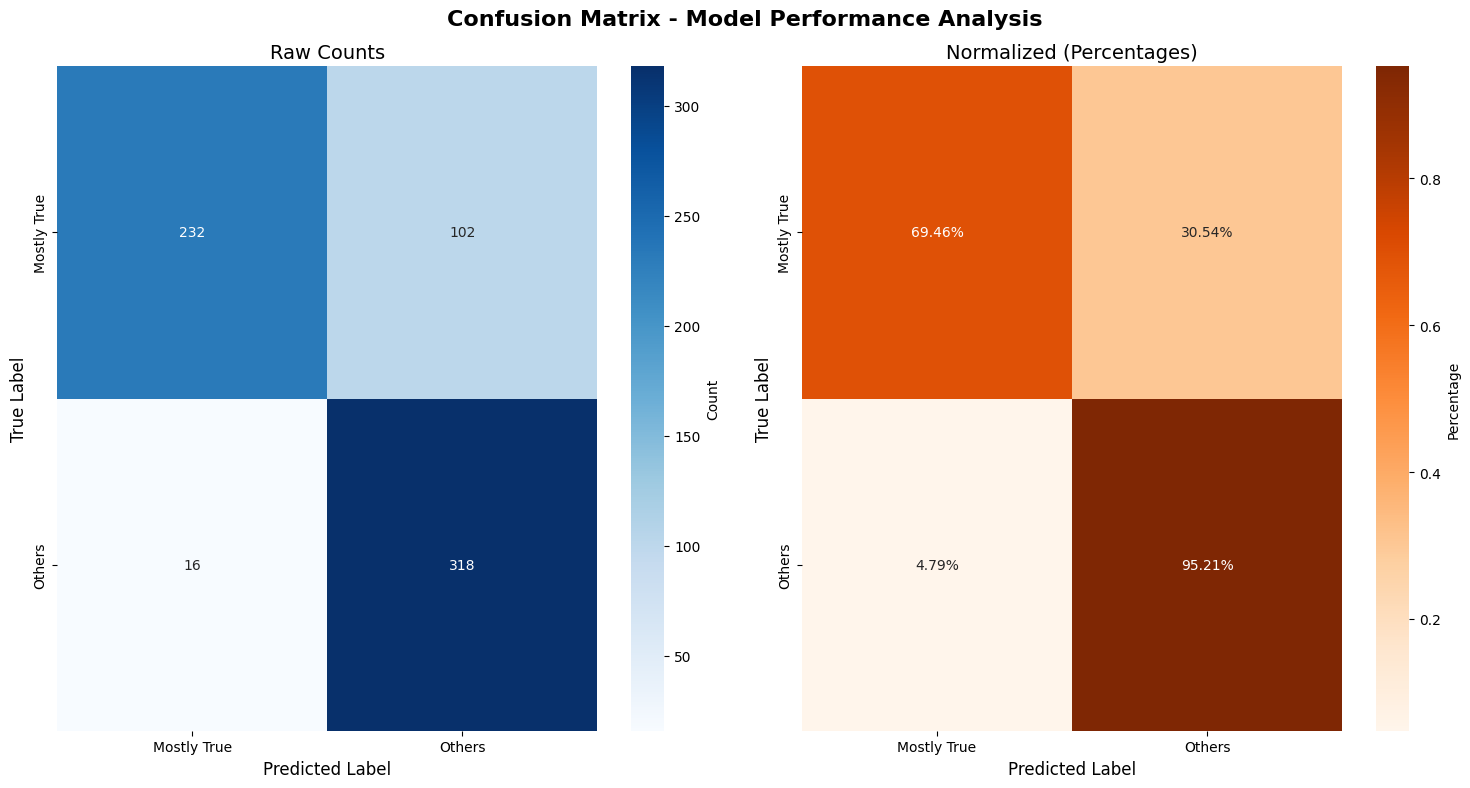

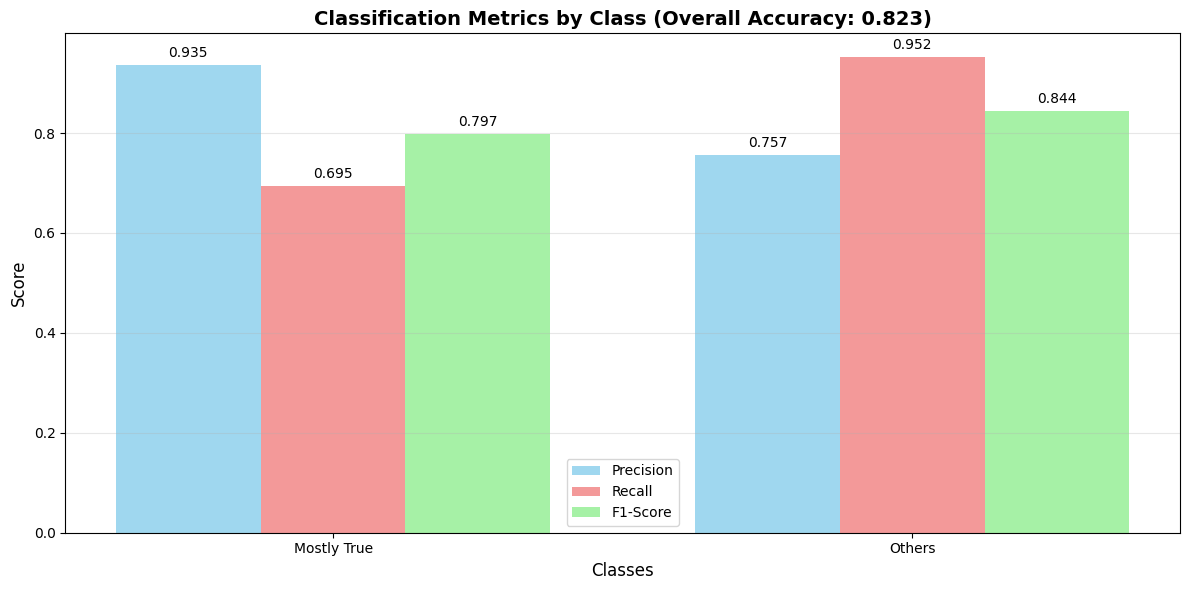

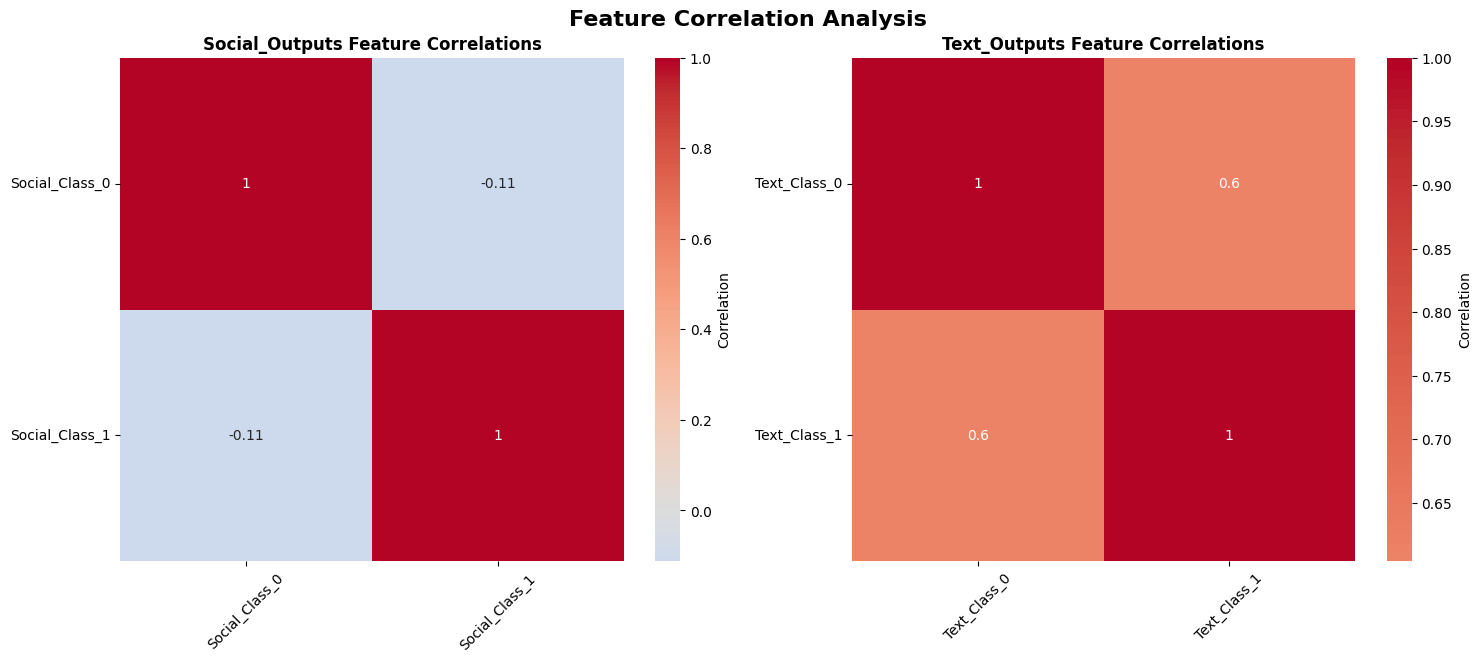

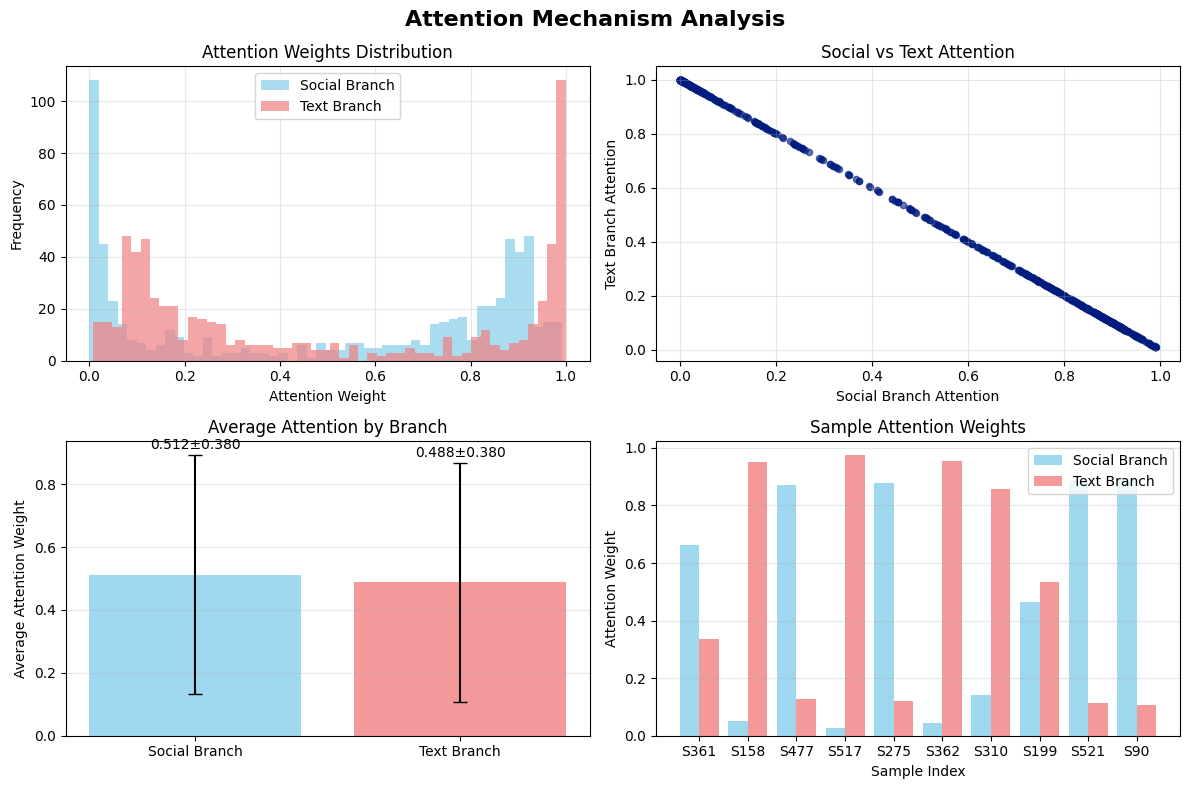


🔍 Analyzing original network features correlation...


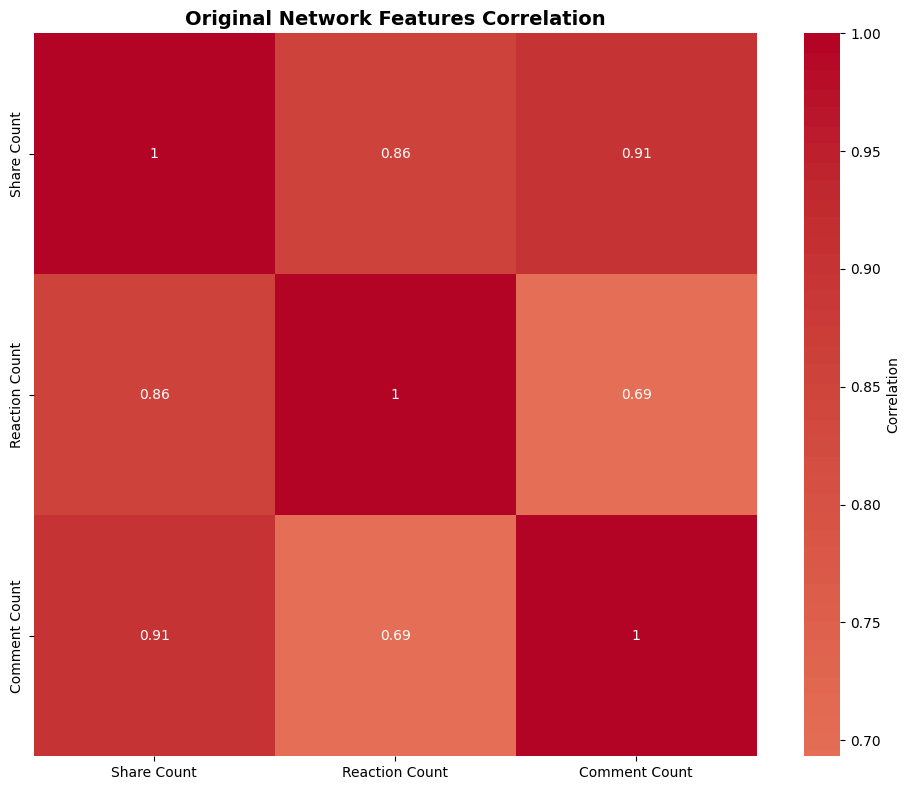


📊 EVALUATION SUMMARY:
------------------------------
Overall Accuracy: 0.8234
Total Test Samples: 668
Correct Predictions: 550

Attention Weights Summary:
Average Social Branch Attention: 0.5120
Average Text Branch Attention: 0.4880
→ Model relies more on social/network features


In [8]:
# ==========================================
# STEP 11: CONFUSION MATRIX AND CORRELATION VISUALIZATION
# ==========================================

def plot_confusion_matrix_enhanced(y_true, y_pred, class_names=['Mostly True', 'Others'],
                                 title='Confusion Matrix', figsize=(15, 8)):
    """
    Create an enhanced confusion matrix visualization with multiple metrics
    """
    from sklearn.metrics import confusion_matrix, classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(f'{title} - Model Performance Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Raw Counts', fontsize=14)
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)

    # Plot 2: Normalized (percentages)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Percentage'})
    axes[1].set_title('Normalized (Percentages)', fontsize=14)
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_ylabel('True Label', fontsize=12)

    plt.tight_layout()
    return fig, cm, cm_normalized

def plot_detailed_classification_metrics(y_true, y_pred, class_names=['Mostly True', 'Others']):
    """
    Create detailed classification metrics visualization
    """
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    import matplotlib.pyplot as plt
    import numpy as np

    # Calculate metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Create metrics dataframe for visualization
    metrics_data = {
        'Class': class_names + ['Macro Avg', 'Weighted Avg'],
        'Precision': list(precision) + [np.mean(precision), np.average(precision, weights=support)],
        'Recall': list(recall) + [np.mean(recall), np.average(recall, weights=support)],
        'F1-Score': list(f1) + [np.mean(f1), np.average(f1, weights=support)],
        'Support': list(support) + [np.sum(support), np.sum(support)]
    }

    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(class_names))
    width = 0.25

    ax.bar(x - width, precision, width, label='Precision', alpha=0.8, color='skyblue')
    ax.bar(x, recall, width, label='Recall', alpha=0.8, color='lightcoral')
    ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8, color='lightgreen')

    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'Classification Metrics by Class (Overall Accuracy: {accuracy:.3f})', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        ax.text(i - width, p + 0.01, f'{p:.3f}', ha='center', va='bottom', fontsize=10)
        ax.text(i, r + 0.01, f'{r:.3f}', ha='center', va='bottom', fontsize=10)
        ax.text(i + width, f + 0.01, f'{f:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    return fig, metrics_data

def plot_feature_correlations(features_dict, feature_names_dict, figsize=(15, 12)):
    """
    Plot correlation matrices for different feature types
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd

    n_feature_types = len(features_dict)
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.ravel() if n_feature_types > 1 else [axes]

    for idx, (feature_type, features) in enumerate(features_dict.items()):
        if idx >= 4:  # Maximum 4 subplots
            break

        # Calculate correlation matrix
        if isinstance(features, torch.Tensor):
            features_np = features.cpu().numpy()
        else:
            features_np = features

        # Create DataFrame for better visualization
        feature_names = feature_names_dict.get(feature_type, [f'Feature_{i}' for i in range(features_np.shape[1])])
        df = pd.DataFrame(features_np, columns=feature_names)
        correlation_matrix = df.corr()

        # Plot heatmap
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, ax=axes[idx], cbar_kws={'label': 'Correlation'})
        axes[idx].set_title(f'{feature_type} Feature Correlations', fontsize=12, fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].tick_params(axis='y', rotation=0)

    # Hide unused subplots
    for idx in range(n_feature_types, 4):
        axes[idx].set_visible(False)

    plt.suptitle('Feature Correlation Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

def plot_attention_weights_analysis(attention_weights, sample_indices=None, figsize=(12, 8)):
    """
    Analyze and visualize attention weights from the fusion layer
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    if isinstance(attention_weights, torch.Tensor):
        attention_weights = attention_weights.cpu().numpy()

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Plot 1: Attention weights distribution
    axes[0, 0].hist(attention_weights[:, 0], bins=50, alpha=0.7, label='Social Branch', color='skyblue')
    axes[0, 0].hist(attention_weights[:, 1], bins=50, alpha=0.7, label='Text Branch', color='lightcoral')
    axes[0, 0].set_xlabel('Attention Weight')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Attention Weights Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Plot 2: Attention weights scatter
    axes[0, 1].scatter(attention_weights[:, 0], attention_weights[:, 1], alpha=0.6, s=20)
    axes[0, 1].set_xlabel('Social Branch Attention')
    axes[0, 1].set_ylabel('Text Branch Attention')
    axes[0, 1].set_title('Social vs Text Attention')
    axes[0, 1].grid(alpha=0.3)

    # Plot 3: Average attention by branch
    branch_names = ['Social Branch', 'Text Branch']
    avg_attention = np.mean(attention_weights, axis=0)
    std_attention = np.std(attention_weights, axis=0)

    bars = axes[1, 0].bar(branch_names, avg_attention, yerr=std_attention,
                         capsize=5, alpha=0.8, color=['skyblue', 'lightcoral'])
    axes[1, 0].set_ylabel('Average Attention Weight')
    axes[1, 0].set_title('Average Attention by Branch')
    axes[1, 0].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, avg, std in zip(bars, avg_attention, std_attention):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                       f'{avg:.3f}±{std:.3f}', ha='center', va='bottom')

    # Plot 4: Sample attention weights (if sample indices provided)
    if sample_indices is not None and len(sample_indices) > 0:
        sample_weights = attention_weights[sample_indices]
        x_pos = np.arange(len(sample_indices))

        axes[1, 1].bar(x_pos - 0.2, sample_weights[:, 0], 0.4,
                      label='Social Branch', alpha=0.8, color='skyblue')
        axes[1, 1].bar(x_pos + 0.2, sample_weights[:, 1], 0.4,
                      label='Text Branch', alpha=0.8, color='lightcoral')
        axes[1, 1].set_xlabel('Sample Index')
        axes[1, 1].set_ylabel('Attention Weight')
        axes[1, 1].set_title('Sample Attention Weights')
        axes[1, 1].set_xticks(x_pos)
        axes[1, 1].set_xticklabels([f'S{i}' for i in sample_indices])
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No sample indices provided',
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Sample Attention Weights (N/A)')

    plt.suptitle('Attention Mechanism Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

def comprehensive_model_evaluation(model, test_loader, device, class_names=['Mostly True', 'Others']):
    """
    Comprehensive model evaluation with all visualizations
    """
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_social_outputs = []
    all_text_outputs = []
    all_attention_weights = []

    print("🔍 Running comprehensive model evaluation...")

    with torch.no_grad():
        for batch_gcn, batch_bert, batch_y in test_loader:
            batch_gcn = batch_gcn.to(device)
            batch_bert = batch_bert.to(device)
            batch_y = batch_y.to(device)

            # Get model outputs
            outputs, social_out, text_out, attention_weights = model(batch_gcn, batch_bert)

            # Store results
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(batch_y.cpu().numpy())
            all_social_outputs.extend(social_out.cpu().numpy())
            all_text_outputs.extend(text_out.cpu().numpy())
            all_attention_weights.extend(attention_weights.cpu().numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_true_labels = np.array(all_true_labels)
    all_social_outputs = np.array(all_social_outputs)
    all_text_outputs = np.array(all_text_outputs)
    all_attention_weights = np.array(all_attention_weights)

    print("✅ Evaluation completed. Generating visualizations...")

    # Generate all visualizations
    results = {}

    # 1. Confusion Matrix
    fig_cm, cm, cm_norm = plot_confusion_matrix_enhanced(all_true_labels, all_predictions, class_names)
    results['confusion_matrix'] = {'figure': fig_cm, 'matrix': cm, 'normalized': cm_norm}

    # 2. Classification Metrics
    fig_metrics, metrics_data = plot_detailed_classification_metrics(all_true_labels, all_predictions, class_names)
    results['classification_metrics'] = {'figure': fig_metrics, 'data': metrics_data}

    # 3. Feature Correlations
    features_dict = {
        'Social_Outputs': all_social_outputs,
        'Text_Outputs': all_text_outputs,
    }
    feature_names_dict = {
        'Social_Outputs': ['Social_Class_0', 'Social_Class_1'],
        'Text_Outputs': ['Text_Class_0', 'Text_Class_1'],
    }
    fig_corr = plot_feature_correlations(features_dict, feature_names_dict)
    results['feature_correlations'] = {'figure': fig_corr}

    # 4. Attention Analysis
    sample_indices = np.random.choice(len(all_attention_weights), min(10, len(all_attention_weights)), replace=False)
    fig_attention = plot_attention_weights_analysis(all_attention_weights, sample_indices)
    results['attention_analysis'] = {'figure': fig_attention, 'weights': all_attention_weights}

    # Display all figures
    plt.show()

    return results

# ==========================================
# INTEGRATION WITH YOUR EXISTING CODE
# ==========================================

# After training your model (add this after your training loop)
def visualize_training_results():
    """
    Call this function after training to generate all visualizations
    """
    print("\n" + "="*50)
    print("GENERATING COMPREHENSIVE VISUALIZATIONS")
    print("="*50)

    # Run comprehensive evaluation
    evaluation_results = comprehensive_model_evaluation(
        model=two_branch_model,
        test_loader=test_loader,
        device=device,
        class_names=['Mostly True', 'Others']
    )

    # Additional network feature correlation analysis
    print("\n🔍 Analyzing original network features correlation...")

    # Create correlation plot for original network features
    network_feature_names = ['Share Count', 'Reaction Count', 'Comment Count']
    original_features = pd.DataFrame(network_features_raw, columns=network_feature_names)

    fig_network_corr, ax = plt.subplots(figsize=(10, 8))
    correlation_matrix = original_features.corr()

    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
               square=True, ax=ax, cbar_kws={'label': 'Correlation'})
    ax.set_title('Original Network Features Correlation', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n📊 EVALUATION SUMMARY:")
    print("-" * 30)
    # Remove the line causing the error:
    # accuracy = accuracy_score(evaluation_results['classification_metrics']['data']['Class'][:2],
    #                         [evaluation_results['classification_metrics']['data']['Precision'][i] for i in range(2)])

    # Calculate overall metrics from confusion matrix
    cm = evaluation_results['confusion_matrix']['matrix']
    total_samples = np.sum(cm)
    correct_predictions = np.trace(cm)
    overall_accuracy = correct_predictions / total_samples

    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Total Test Samples: {total_samples}")
    print(f"Correct Predictions: {correct_predictions}")

    # Attention weights summary
    attention_weights = evaluation_results['attention_analysis']['weights']
    avg_social_attention = np.mean(attention_weights[:, 0])
    avg_text_attention = np.mean(attention_weights[:, 1])

    print(f"\nAttention Weights Summary:")
    print(f"Average Social Branch Attention: {avg_social_attention:.4f}")
    print(f"Average Text Branch Attention: {avg_text_attention:.4f}")

    if avg_social_attention > avg_text_attention:
        print("→ Model relies more on social/network features")
    else:
        print("→ Model relies more on text features")

    return evaluation_results

# ==========================================
# USAGE EXAMPLE
# ==========================================

# After your training loop completes, call:
evaluation_results = visualize_training_results()